Now that we've trained a fairly straightforward Season ARIMA model, we're going to look at a slightly more complex case. You've been contracted by a large pharmaceutical company to help improve their sales predictions. Some medicines follow very predictable patterns, but are largely affected by external factors. For example, while cold medicine has strong seasonal patterns, shifts in global temperature and differences in birth rates can have non-seasonal affects on sales data.

We're going to investigate sales of a Corticosteroid drug in Australia. They are a class of steroid hormones used to treat anything from brain tumors to skin diseases. Our data set contains 203 observations of drug sales over the course of 1991-2008 sampled monthly. Each observation is reported as Millions of scripts per month.

Their head Data Scientist will be meeting with you to discuss your findings. They will expect you to report top level findings in the form of a text document (this won't be client facing, just log your observations in a neat format), supported by a code walk-through where you should be prepared to defend your decisions.

**NOTE:** Being able to explain a choice is more important than whether or not you make the right decision, not only in interviews but in every interaction you will have as a Data Scientist.

## Exercise

#### Requirements

- Load in the data and perform EDA. Record your observations regarding trend, seasonality, stationarity, etc.
- Clean the data if needed and perform any transformations you deem necessary. Don't forget to document the decisions you made, and why you made them!
- Be sure to plot ACF/PACF along the way, and record any observations you may have.
- Keep a log of each model you audition, along with their AIC values (Dickey-Fuller Test). You should be auditioning at least half a dozen models.
- Determine if Seasonal Differencing is needed. Make a note as to your decision, with graphical evidence to support.
- Clearly address the logic behind your choices for all 7 terms (3 seasonal, 3 non-seasonal, and seasonal periods).
- Utilize the Ljung-Box test to determine fit for your model (Dickey-Fuller Test). Record all observations.
- Provide both in-sample ("using current data to find correlations") and out-of-sample ("using past data to make predictions of the future") forecasts for at least 3 different models. Summarize the resulting RSME values in your iPython notebook.

#### Starter code

Training wheels are off! You'll be starting this one from scratch. By now you should be comfortable loading data into an ipython notebook, so we'll let you take it from here.

#### Deliverable

You are expected to audition at least 6 different ARIMA models, and provide forecasts for 3 of them. A clear and easy to read log of your observations will be needed to back up the decisions made in your code.

Your code should be properly documented in an iPython notebook.


In [74]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [75]:
data = pd.read_csv('assets/datasets/h02.csv')
print data.head()
# print '\n Data Types:'
# print data.dtypes

   1991-07  0.429795
0  1991-08  0.400906
1  1991-09  0.432159
2  1991-10  0.492543
3  1991-11  0.502369
4  1991-12  0.602652


In [76]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('./assets/datasets/h02.csv', parse_dates=True, index_col='1991-07', date_parser=dateparse)
data.columns = ['Values']
data.index.name = 'Month'
data.head()

Values
Month               
1991-08-01  0.400906
1991-09-01  0.432159
1991-10-01  0.492543
1991-11-01  0.502369
1991-12-01  0.602652

In [77]:
print len(data)

203


In [78]:
data.index

DatetimeIndex(['1991-08-01', '1991-09-01', '1991-10-01', '1991-11-01',
               '1991-12-01', '1992-01-01', '1992-02-01', '1992-03-01',
               '1992-04-01', '1992-05-01',
               ...
               '2007-09-01', '2007-10-01', '2007-11-01', '2007-12-01',
               '2008-01-01', '2008-02-01', '2008-03-01', '2008-04-01',
               '2008-05-01', '2008-06-01'],
              dtype='datetime64[ns]', name=u'Month', length=203, freq=None)

In [79]:
ts = data['Values'] 
ts.head(10)

#1. Specific the index as a string constant:
print ts['1991-08-01']

# #2. Import the datetime library and use 'datetime' function:
from datetime import datetime
print ts[datetime(1991,8,1)]

0.400906
0.400906


In [105]:
#selecting certain ranges
ts[:'1991']

Month
1991-08-01    0.400906
1991-09-01    0.432159
1991-10-01    0.492543
1991-11-01    0.502369
1991-12-01    0.602652
Name: Values, dtype: float64

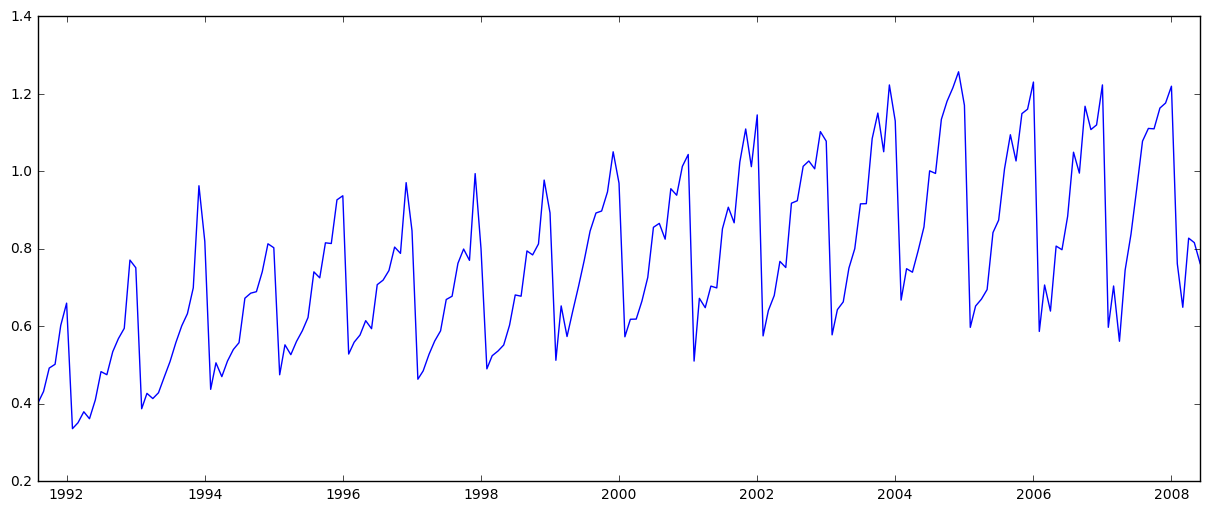

In [106]:
plt.plot(ts)

In [107]:
from statsmodels.tsa.stattools import adfuller

#this will tell you if the timseries is stationary
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

/Users/dnay/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/Users/dnay/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


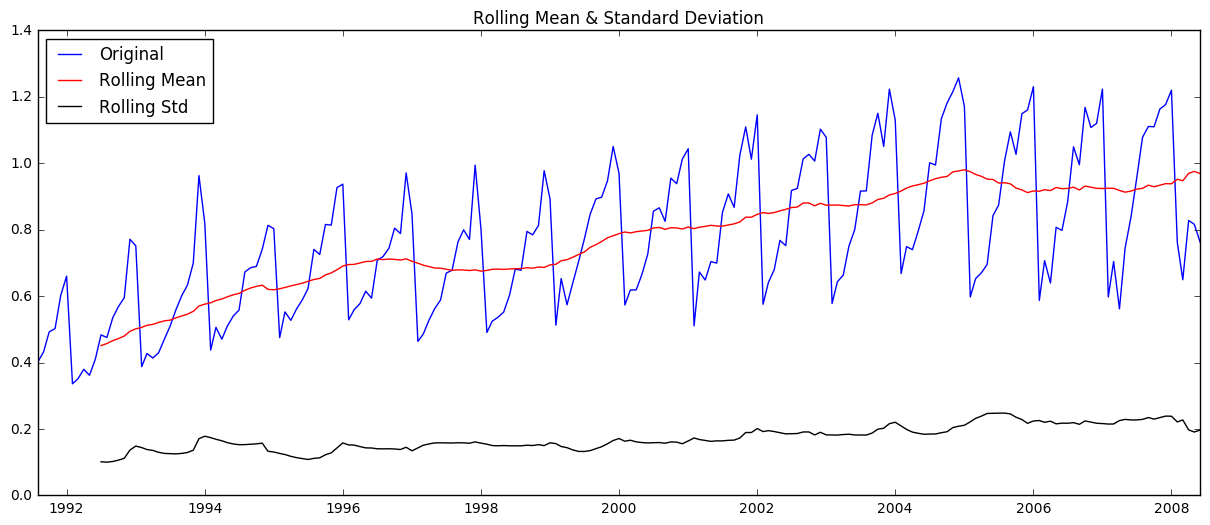

Results of Dickey-Fuller Test:
Test Statistic                  -1.653022
p-value                          0.455465
#Lags Used                      15.000000
Number of Observations Used    187.000000
Critical Value (5%)             -2.877123
Critical Value (1%)             -3.465812
Critical Value (10%)            -2.575077
dtype: float64


In [108]:
test_stationarity(ts)

One of the first tricks to reduce trend can be transformation. For example, in this case we can clearly 
see that the there is a significant positive trend. So we can apply transformation which penalize 
higher values more than smaller values. These can be taking a log, square root, cube root, etc. 
Lets take a log transform here for simplicity:

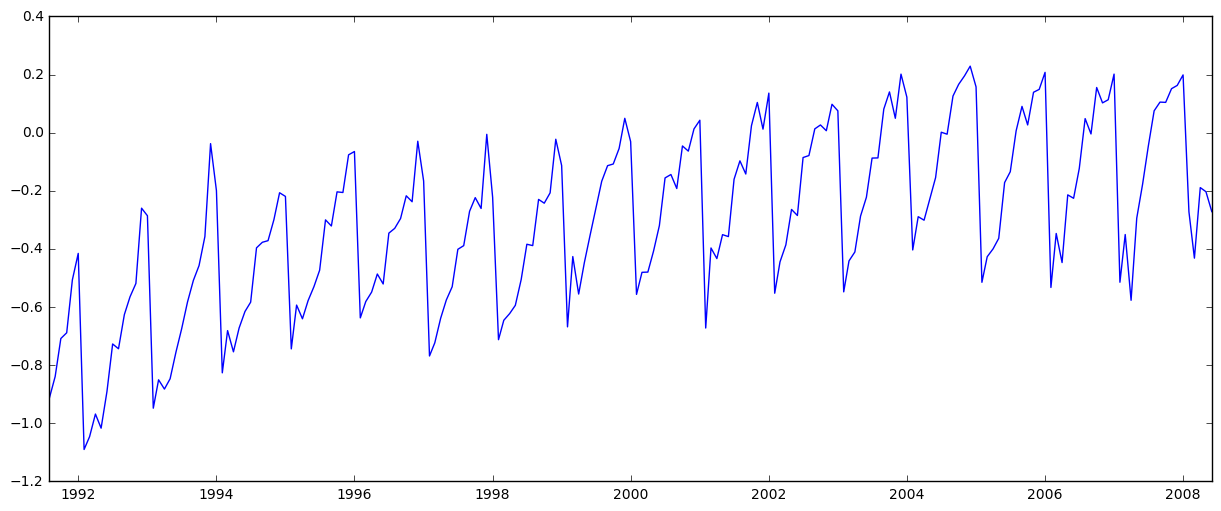

In [84]:
ts_log = np.log(ts)
plt.plot(ts_log)

In this simpler case, it is easy to see a forward trend in the data. But its not very intuitive 
in presence of noise. So we can use some techniques to estimate or model this trend and 
then remove it from the series. There can be many ways of doing it and some of most commonly used are:

Aggregation – taking average for a time period like monthly/weekly averages
Smoothing – taking rolling averages
Polynomial Fitting – fit a regression model


## Moving average

In this approach, we take average of ‘k’ consecutive values depending on the frequency of time 
series. Here we can take the average over the past 1 year, i.e. last 12 values. Pandas has specific 
functions defined for determining rolling statistics.

/Users/dnay/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  if __name__ == '__main__':


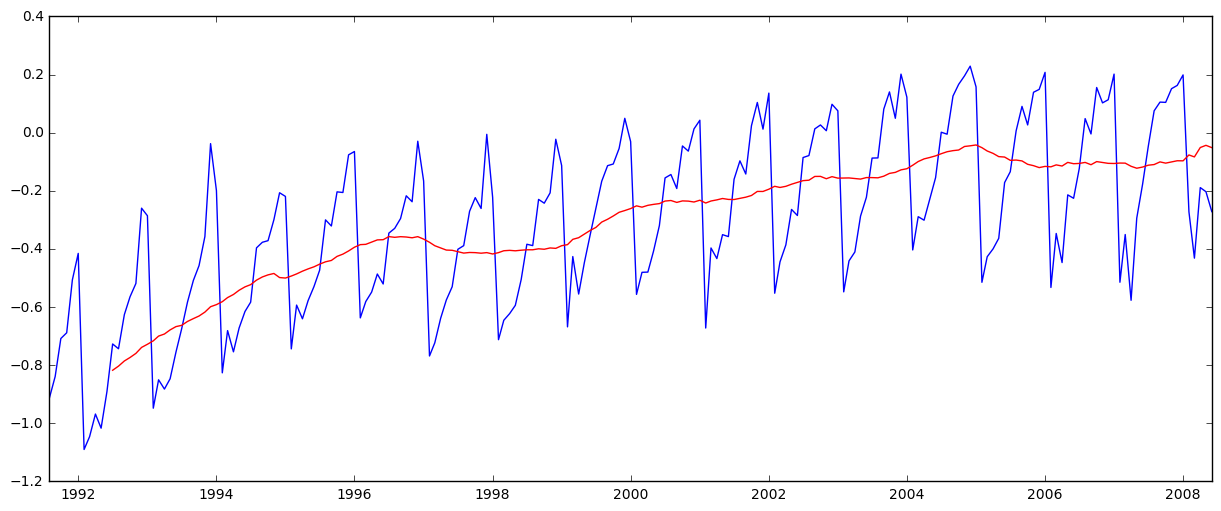

In [85]:
moving_avg = pd.rolling_mean(ts_log,12)
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

The red line shows the rolling mean. Lets subtract this from the original series. Note that since we are taking average of last 12 values, rolling mean is not defined for first 11 values. This can be observed as:

In [86]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

Month
1991-08-01         NaN
1991-09-01         NaN
1991-10-01         NaN
1991-11-01         NaN
1991-12-01         NaN
1992-01-01         NaN
1992-02-01         NaN
1992-03-01         NaN
1992-04-01         NaN
1992-05-01         NaN
1992-06-01         NaN
1992-07-01    0.090506
Name: Values, dtype: float64

/Users/dnay/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/Users/dnay/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


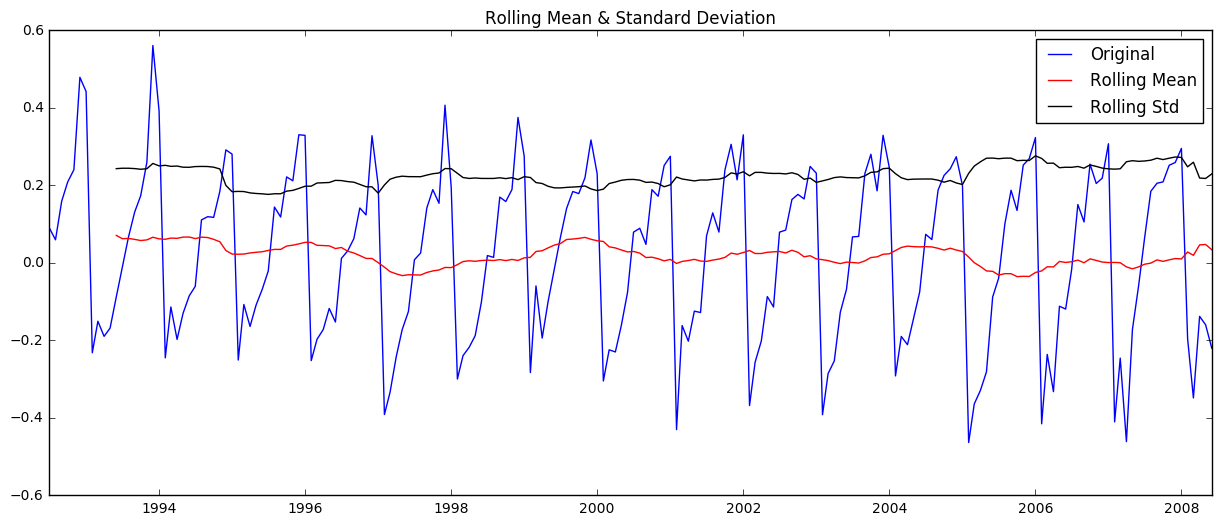

Results of Dickey-Fuller Test:
Test Statistic                  -3.242444
p-value                          0.017656
#Lags Used                      15.000000
Number of Observations Used    176.000000
Critical Value (5%)             -2.878106
Critical Value (1%)             -3.468062
Critical Value (10%)            -2.575602
dtype: float64


In [87]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

This looks like a much better series. The rolling values appear to be varying slightly but there is no specific trend. Also, the test statistic is smaller than the 5% critical values so we can say with 95% confidence that this is a stationary series.

However, a drawback in this particular approach is that the time-period has to be strictly defined. 
In this case we can take yearly averages but in complex situations like forecasting a stock price, 
its difficult to come up with a number. So we take a ‘weighted moving average’ where more recent values 
are given a higher weight. There can be many technique for assigning weights. A popular one is **exponentially 
weighted moving average** where weights are assigned to all the previous values with a decay factor. 
This can be implemented in Pandas as:

/Users/dnay/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(halflife=12,ignore_na=False,min_periods=0,adjust=True).mean()
  if __name__ == '__main__':


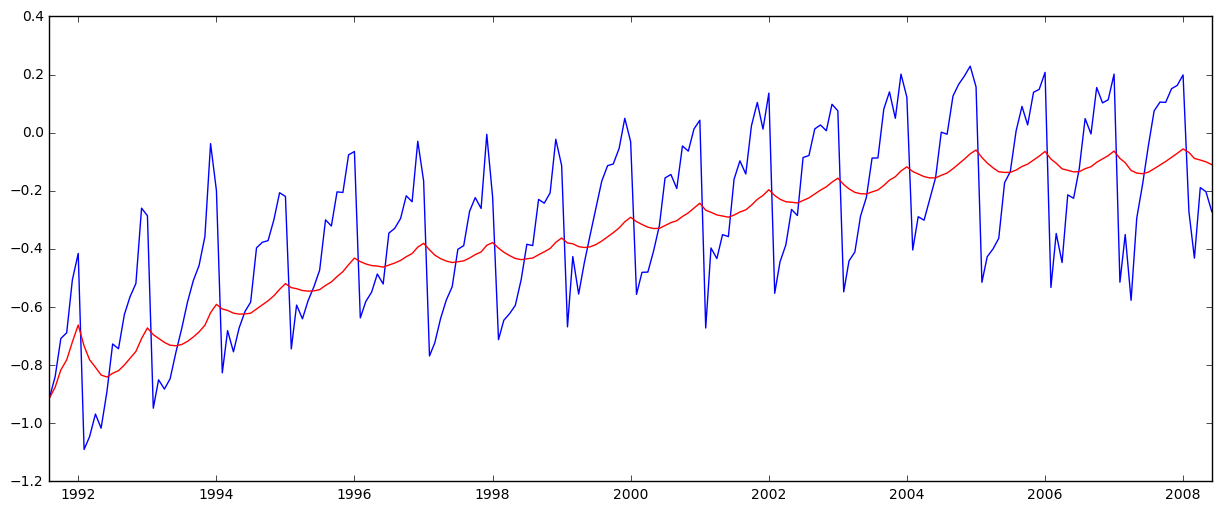

In [88]:
expwighted_avg = pd.ewma(ts_log, halflife=12)
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

Note that here the parameter ‘halflife’ is used to define the amount of exponential decay. This is just an assumption here and would depend largely on the business domain. Other parameters like span and center of mass can also be used to define decay which are discussed in the link shared above. Now, let’s remove this from series and check stationarity:

/Users/dnay/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/Users/dnay/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


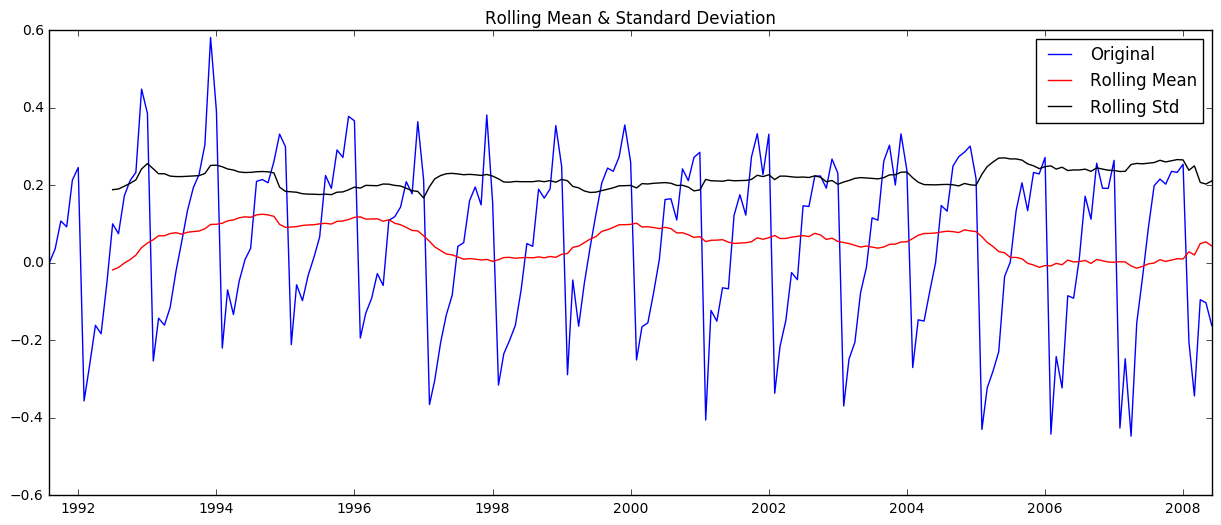

Results of Dickey-Fuller Test:
Test Statistic                  -3.053401
p-value                          0.030199
#Lags Used                      14.000000
Number of Observations Used    188.000000
Critical Value (5%)             -2.877040
Critical Value (1%)             -3.465620
Critical Value (10%)            -2.575032
dtype: float64


In [89]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

This TS has even lesser variations in mean and standard deviation in magnitude. Also, the test statistic is smaller than the 1% critical value, which is better than the previous case. Note that in this case there will be no missing values as all values from starting are given weights. So it’ll work even with no previous values.

## Eliminating Trend and Seasonality

The simple trend reduction techniques discussed before don’t work in all cases, particularly the ones 
with high seasonality. Lets discuss two ways of removing trend and seasonality:

Differencing – taking the differece with a particular time lag
Decomposition – modeling both trend and seasonality and removing them from the model.
Differencing

One of the most common methods of dealing with both trend and seasonality is differencing. 
In this technique, we take the difference of the observation at a particular instant with that at 
the previous instant. This mostly works well in improving stationarity. First order differencing 
can be done in Pandas as:



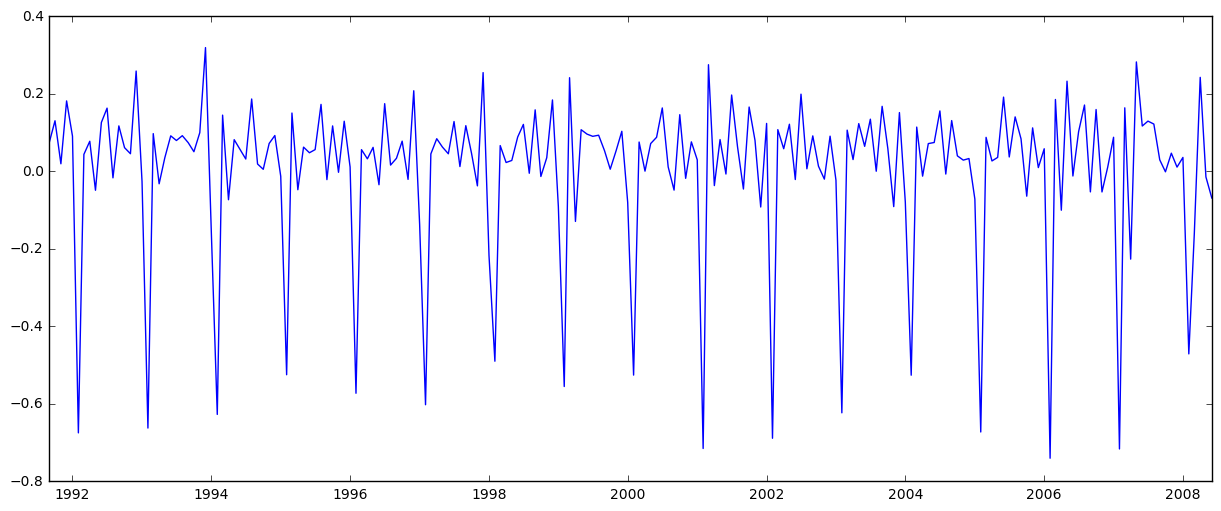

In [90]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

This appears to have reduced trend considerably. Lets verify using our plots:

/Users/dnay/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/Users/dnay/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


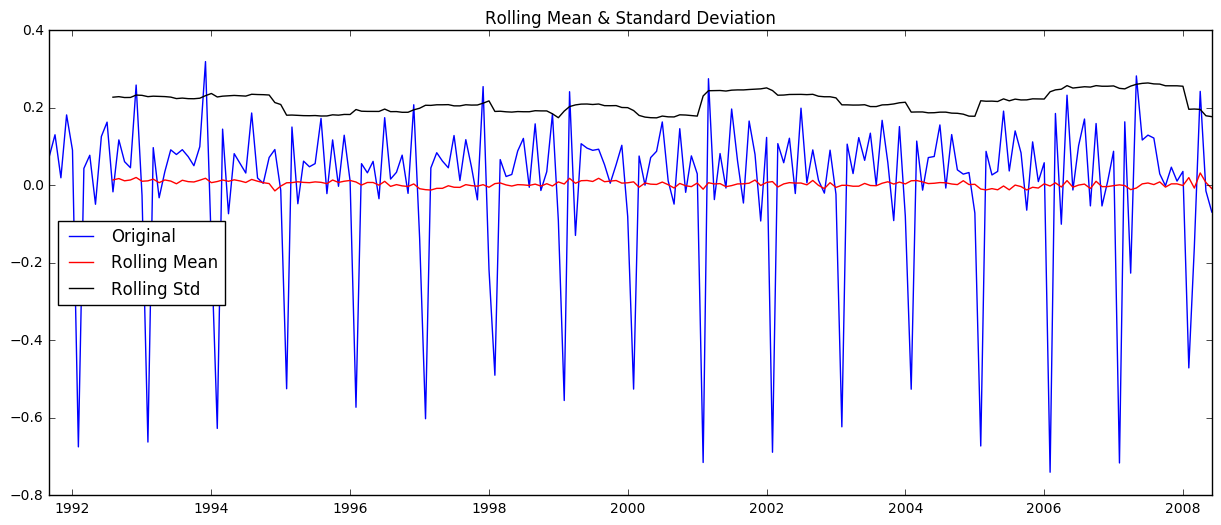

Results of Dickey-Fuller Test:
Test Statistic                  -3.274251
p-value                          0.016069
#Lags Used                      15.000000
Number of Observations Used    186.000000
Critical Value (5%)             -2.877208
Critical Value (1%)             -3.466005
Critical Value (10%)            -2.575122
dtype: float64


In [91]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

We can see that the mean and std variations have small variations with time. Also, the 
Dickey-Fuller test statistic is less than the 10% critical value, thus the TS is stationary with 90% confidence. 
We can also take second or third order differences which might get even better results in certain applications. 

## Decomposing

In this approach, both trend and seasonality are modeled separately and the remaining part of 
the series is returned. I’ll skip the statistics and come to the results:

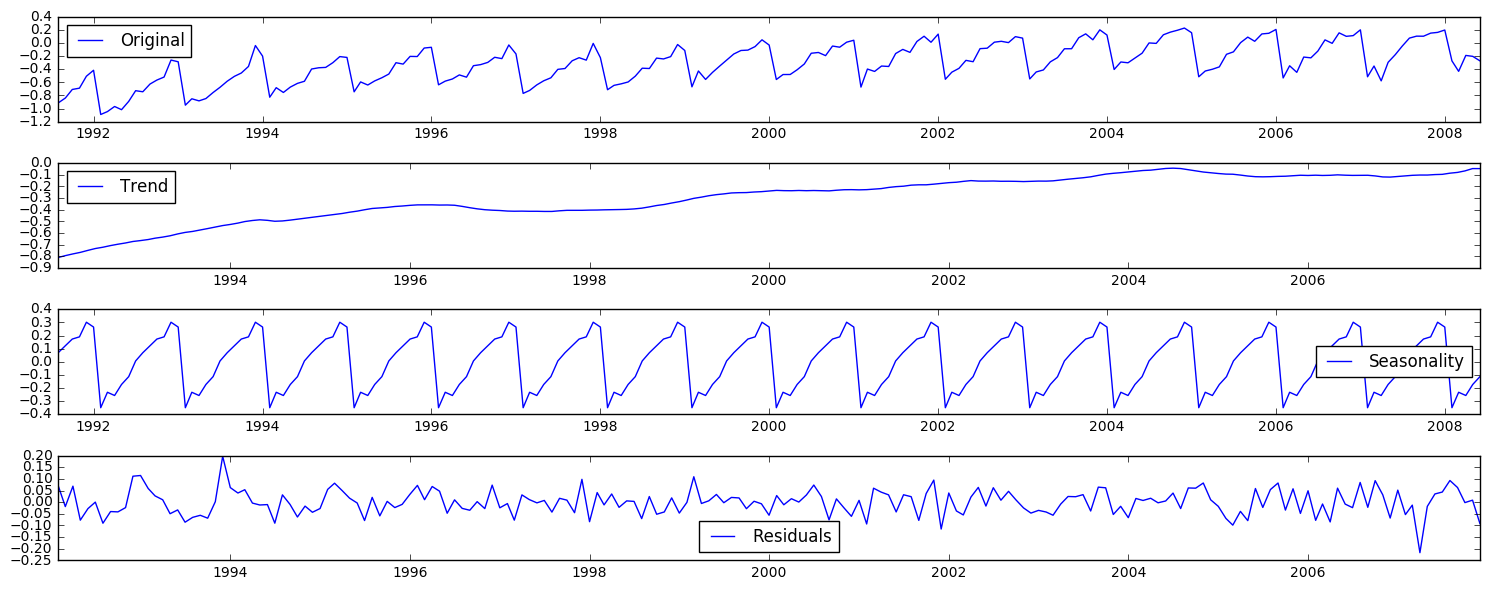

In [92]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Here we can see that the trend, seasonality are separated out from data and we can model the 
residuals. Lets check stationarity of residuals:

/Users/dnay/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/Users/dnay/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


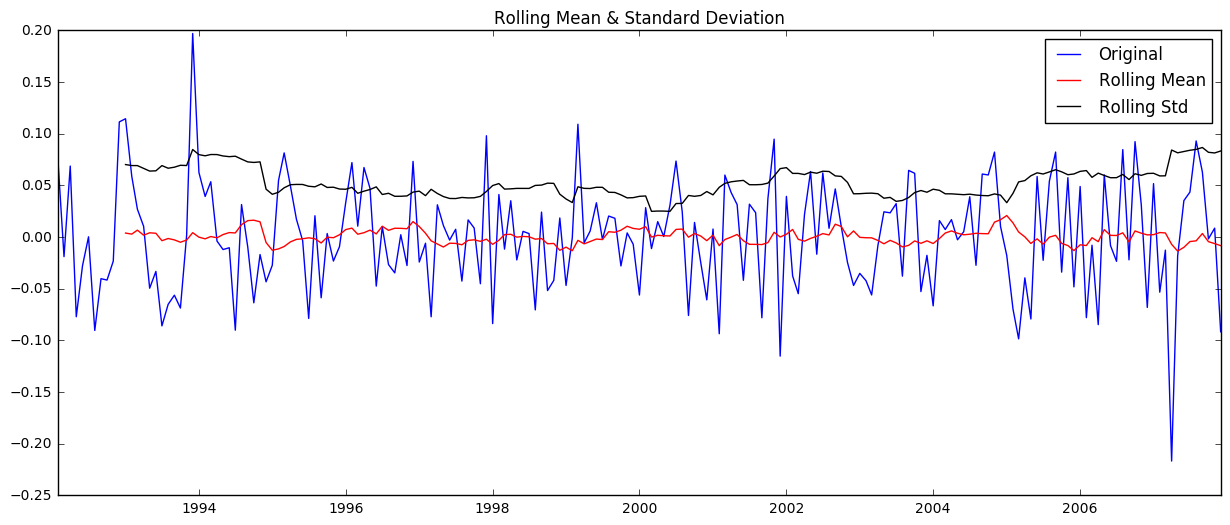

Results of Dickey-Fuller Test:
Test Statistic                -6.124142e+00
p-value                        8.711042e-08
#Lags Used                     1.100000e+01
Number of Observations Used    1.790000e+02
Critical Value (5%)           -2.877826e+00
Critical Value (1%)           -3.467420e+00
Critical Value (10%)          -2.575452e+00
dtype: float64


In [93]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

In [94]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [109]:
lag_acf = acf(residual, nlags=20)
lag_pacf = pacf(residual, nlags=20, method='ols')

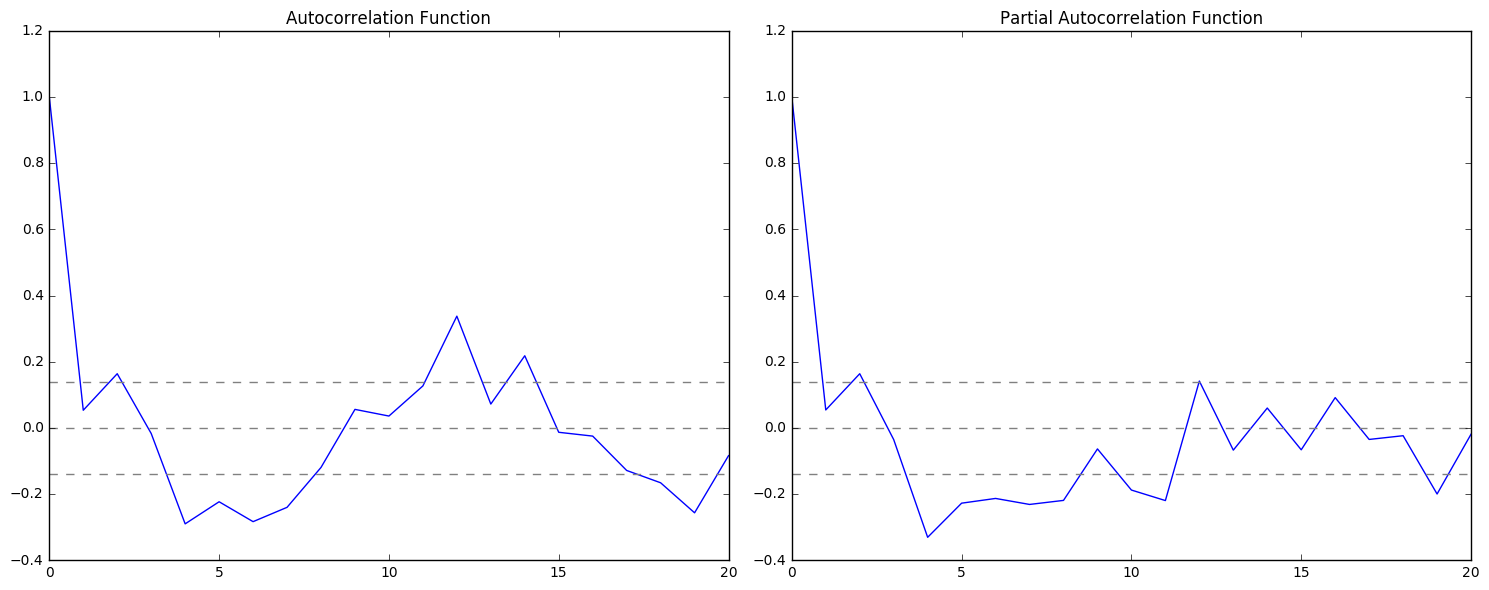

In [110]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In this plot, the two dotted lines on either sides of 0 are the confidence interevals. These can be used to determine the ‘p’ and ‘q’ values as:

p – The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=2.

q – The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=2.

Now, lets make 3 different ARIMA models considering individual as well as combined effects. Please note that here RSS is for the values of residuals and not actual series.

In [111]:
from statsmodels.tsa.arima_model import ARIMA

The p,d,q values can be specified using the order argument of ARIMA which take a tuple (p,d,q). Let model the 3 cases:

## AR model

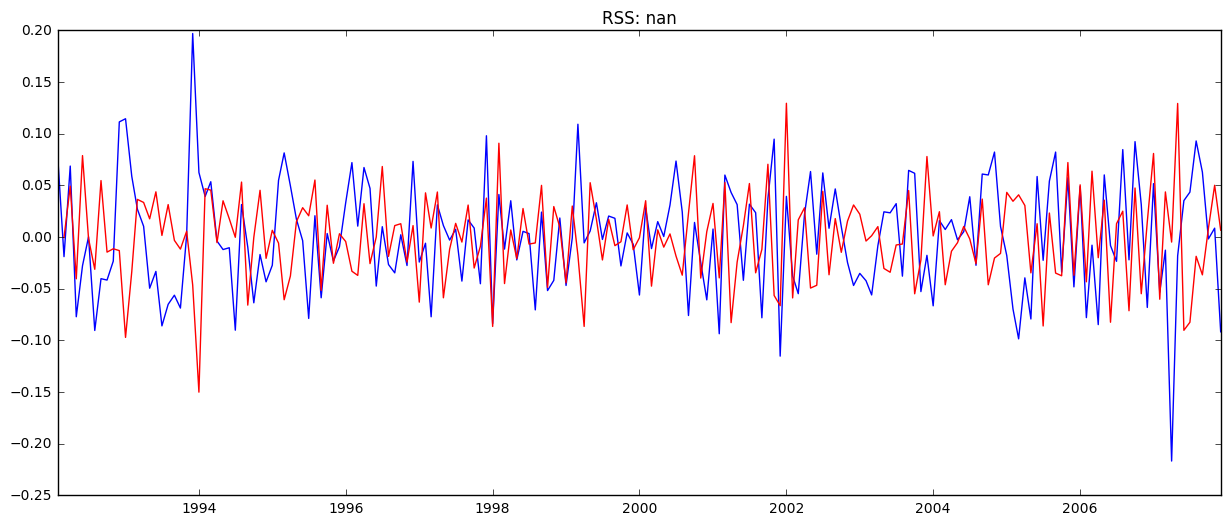

In [112]:
model = ARIMA(residual, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(residual)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

## MA model

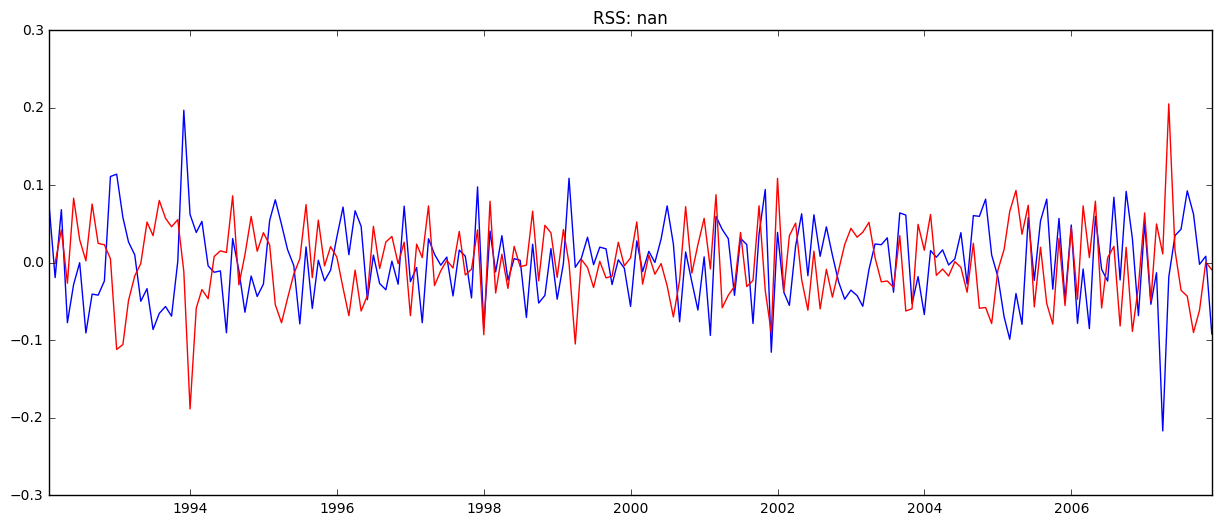

In [113]:
model = ARIMA(residual, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(residual)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

## Combined model

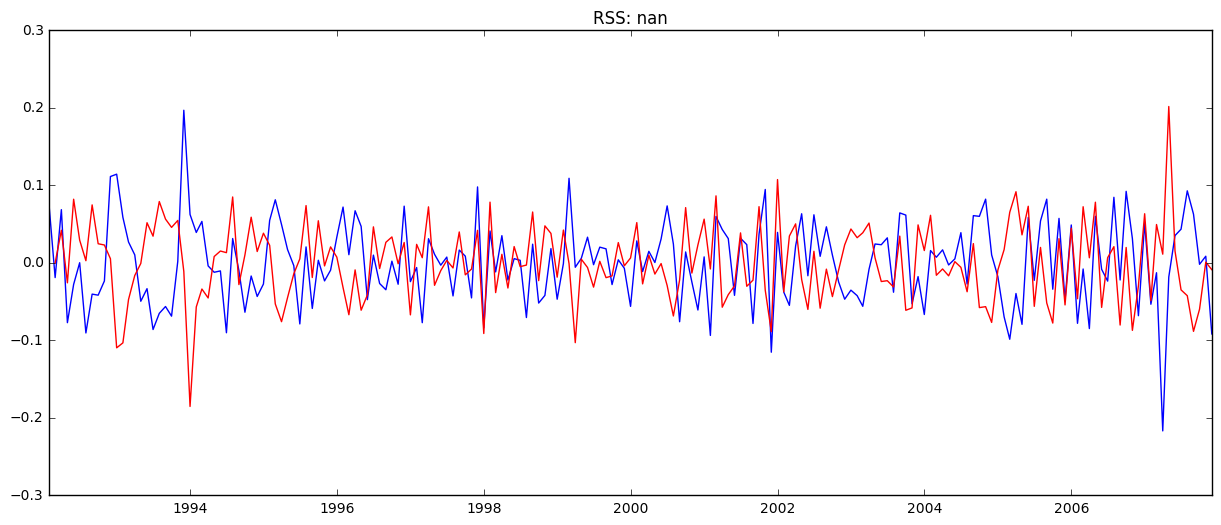

In [119]:
model = ARIMA(residual, order=(1, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(residual)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

Here we can see that the AR and MA models have almost the same RSS but combined is significantly better. Now, we are left with 1 last step, i.e. taking these values back to the original scale.

## Taking it back to original scale

Since the combined model gave best result, lets scale it back to the original values and see how well it performs there. First step would be to store the predicted results as a separate series and observe it.

In [120]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print predictions_ARIMA_diff.head()

Month
1992-03-01   -0.000012
1992-04-01    0.042162
1992-05-01   -0.025652
1992-06-01    0.082220
1992-07-01    0.029415
dtype: float64


In [124]:
predictions_ARIMA_diff_wtrend = predictions_ARIMA_diff + trend
print predictions_ARIMA_diff_wtrend.head()

Month
1991-08-01   NaN
1991-09-01   NaN
1991-10-01   NaN
1991-11-01   NaN
1991-12-01   NaN
dtype: float64


The way to convert the differencing to log scale is to add these differences consecutively to the base number. An easy way to do it is to first determine the cumulative sum at index and then add it to the base number. The cumulative sum can be found as:



In [125]:
predictions_ARIMA_diff_wseason = predictions_ARIMA_diff_wtrend + seasonal
print predictions_ARIMA_diff_wseason.head()

Month
1991-08-01   NaN
1991-09-01   NaN
1991-10-01   NaN
1991-11-01   NaN
1991-12-01   NaN
dtype: float64


Next we’ve to add them to base number. For this lets create a series with all values as base number and add the differences to it. This can be done as:



In [128]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_wseason,fill_value=0)
predictions_ARIMA_log.head()

Month
1991-08-01   -0.914028
1991-09-01   -0.914028
1991-10-01   -0.914028
1991-11-01   -0.914028
1991-12-01   -0.914028
dtype: float64

Here the first element is base number itself and from thereon the values cumulatively added. Last step is to take the exponent and compare with the original series.

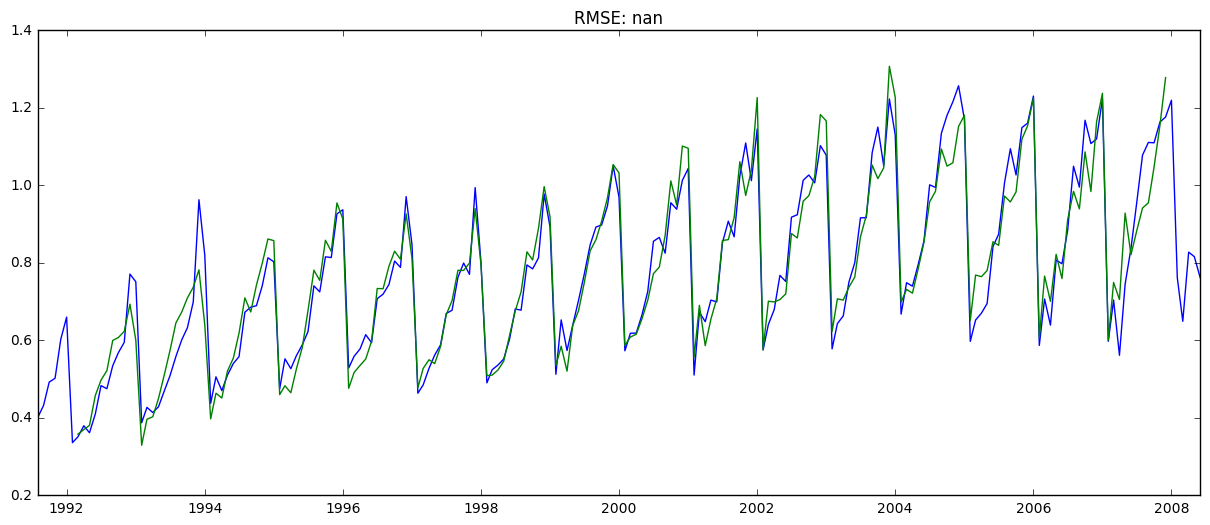

In [129]:
predictions_ARIMA = np.exp(predictions_ARIMA_diff_wseason)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))